<a href="https://colab.research.google.com/github/mskmei/MIDTERM-PROJECT-CV-2022Spring/blob/main/CIFAR100/notebook/CIFAR100_paddle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-100 with ResNet and Data Augmentation

Author: [https://github.com/ForeverHaibara](https://github.com/ForeverHaibara)

In this experiment we demonstrate how to train a ResNet on CIFAR-100 with data augmentation.

CIFAR-100: [http://www.cs.toronto.edu/~kriz/cifar.html](http://www.cs.toronto.edu/~kriz/cifar.html)

In [39]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
from tqdm import tqdm 

In [40]:
from torchvision.datasets import CIFAR100
data = CIFAR100(root = './', train = True, download = True)
data_train = {'data': np.array([np.array(data[i][0]) for i in range(50000)]),
        'fine_labels': np.array([data[i][1] for i in range(50000)], dtype='uint8')}
del data 

data = CIFAR100(root = './', train = False, download = True)
data_test = {'data': np.array([np.array(data[i][0]) for i in range(10000)]),
        'fine_labels': np.array([data[i][1] for i in range(10000)], dtype='uint8')}
del data

Files already downloaded and verified
Files already downloaded and verified


In [41]:
# all classes of CIFAR-100
data_meta = 'apple aquarium_fish baby bear beaver bed bee beetle bicycle bottle bowl boy bridge bus butterfly camel can castle caterpillar cattle chair chimpanzee clock cloud cockroach couch crab crocodile cup dinosaur dolphin elephant flatfish forest fox girl hamster house kangaroo keyboard lamp lawn_mower leopard lion lizard lobster man maple_tree motorcycle mountain mouse mushroom oak_tree orange orchid otter palm_tree pear pickup_truck pine_tree plain plate poppy porcupine possum rabbit raccoon ray road rocket rose sea seal shark shrew skunk skyscraper snail snake spider squirrel streetcar sunflower sweet_pepper table tank telephone television tiger tractor train trout tulip turtle wardrobe whale willow_tree wolf woman worm'.split()
data_meta = {'fine_label_names': data_meta}
print(len(data_meta['fine_label_names']))

100


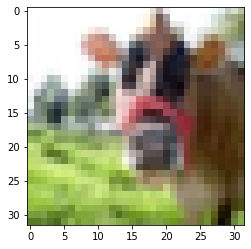

In [4]:
plt.imshow(data_train['data'][0])

## Data Augmentation


We implement the Cutout, Mixup and CutMix.

Reference:

Cutout [https://arxiv.org/abs/1708.04552](https://arxiv.org/abs/1708.04552)

Mixup [https://arxiv.org/abs/1710.09412v2](https://arxiv.org/abs/1710.09412v2)

CutMix [https://arxiv.org/abs/1905.04899](https://arxiv.org/abs/1905.04899)

In [42]:
from PIL import Image 
def augmentate(pics, labels = None, resize = (224, 224), augmentation = False, 
                cut = False, mix = False, rotate = 15):
    '''Simple data augmentator'''
    pics2 = []
    n = pics.shape[0]
    if resize is None:
        resize = pics[0].shape 
    
    if augmentation:
        angles = (np.random.random(n) - .5) * (rotate * 2.)
        flips = np.random.randint(0, 2, n)
        for i in range(n):
            pic = Image.fromarray(pics[i])
            if flips[i]: pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = pic.rotate(angles[i])
            pic = np.array(pic)
            pics2.append(pic)
    
        if cut and not mix:
            # cutout
            cutx = np.random.randint(cut, resize[0], n)
            cuty = np.random.randint(cut, resize[1], n)
            for i in range(n):
                pics2[i][cutx[i]-cut : cutx[i], 
                         cuty[i]-cut : cuty[i], : ] = 0
            labels *= (1. - cut * cut / pics2[0].size)

        elif mix and not cut:
            # mixup
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)

            # warning: do not modify in-place
            pics3 = [propotion[i] * pics2[couple[i]] + (1 - propotion[i]) * pics2[i] 
                        for i in range(n)]

            # pointer
            pics2 = pics3 

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))

        elif cut and mix:
            # cutmix
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)
            rw = (resize[0] * np.sqrt(propotion)).astype('uint8')
            rh = ((resize[1] / resize[0]) * rw).astype('uint8')

            rx = np.random.randint(65535, size = n) % (resize[0] - rw)
            ry = np.random.randint(65535, size = n) % (resize[1] - rh)

            # warning: do not modify in-place
            pics3 = np.array(pics2)
            for i in range(n):
                pics3[i][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] = \
                    pics2[couple[i]][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] 

            # pointer
            pics2 = pics3

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))
            
    else: 
        # no augmentation but resizing
        for i in range(pics.shape[0]):
            pic = Image.fromarray(pics[i])
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = np.array(pic)
            pics2.append(pic)

    return np.array(pics2), labels

def resizer(pics, size):
    '''
    resize pictures to the given size
    '''
    if issubclass(type(pics[0]), np.ndarray):
        pics = [Image.fromarray(pic) for pic in pics]
    
    for i in range(len(pics)):
        pics[i] = pics[i].resize(size, Image.ANTIALIAS)
    
    return pics


def dataloader(data, labels, batch_size = 128, shuffle = True, verbose = True,
                resize = (224,224), augmentation = True, onehot = False,
                cut = False, mix = False, rotate = 15):
    order = np.arange(data.shape[0], dtype = 'int32')
    if shuffle: np.random.shuffle(order)
    labels = np.array(labels)
    __eye = np.eye(np.max(labels) + 1)
    gen = range(data.shape[0] // batch_size)
    if verbose: gen = tqdm(gen)
    for i in gen:
        x = data[order[i * batch_size: i * batch_size + batch_size]]
        l = labels[order[i * batch_size: i * batch_size + batch_size]]

        # extract the onehot encoding
        l = __eye[l]

        # augmentate the data
        x , l = augmentate(x, l, resize = resize, augmentation = augmentation, 
                            cut = cut, mix = mix, rotate = rotate)

        # transpose the dimensions to match (N,C,H,W)
        x = x.transpose((0,3,1,2))
        x = torch.tensor(x, dtype = torch.float32) / 255.

        # retrieve the non-onehot encoding if asked
        if not onehot:
            l = labels[order[i * batch_size: i * batch_size + batch_size]]
        yield x , l



def topk(y, labels, top):
    '''compute the number of hits in the top-k prediction'''
    topy = np.argpartition(y, -top, axis=-1)[:,-top:]
    topy -= labels.reshape((labels.shape[0], 1))
    return topy.size - np.count_nonzero(topy)


def test(net, data, batch_size = 100, resize = (224,224), tops = [1,5],
            verbose = False, label = 'fine', augmentation = False):
    accs = [0] * len(tops)
    tops.sort()
    for x, labels in dataloader(data['data'], data[f'{label}_labels'], resize = resize, 
                                  batch_size = batch_size, shuffle = False, verbose = verbose,
                                  augmentation = augmentation):
        y = net(x.to(_cuda_)).cpu().detach().numpy()
        labels = np.array(labels)
        for i in range(len(tops)):
            t = topk(y, labels, tops[i])
            accs[i] += topk(y, labels, tops[i])
    return np.array(accs) / data['data'].shape[0]

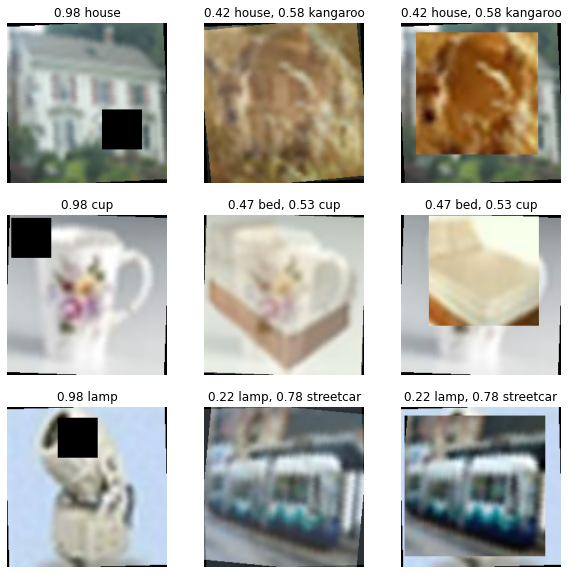

In [43]:
plt.figure(figsize=(10,10))
for i, method in enumerate(((56,False), (0, True), (56, True))):
    np.random.seed(31415)
    for pics in dataloader(data_train['data'], data_train['fine_labels'], verbose = False,
                augmentation=True, onehot = True, cut = method[0], mix = method[1], rotate = 6):
        for j in range(3):
            plt.subplot(3,3,i + j*3 + 1)
            plt.imshow(pics[0][j].numpy().transpose((1,2,0)))
            plt.axis('off')
            plt.title(''.join([('%.2f %s, '%(p, data_meta['fine_label_names'][index]) if p > 0 else '')
                            for index, p in enumerate(pics[1][j])])[:-2] )
        break
plt.savefig('augmentation.png', bbox_inches='tight')

## Training

As a demo, we use the pretrained network and train around **??? minutes** on GPU.

In [44]:
_cuda_ = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(_cuda_)

cpu


In [54]:
import torchvision

class Net(torch.nn.Module):
    def __init__(self, backbone, num_classes = 100):
        super().__init__()
        self.head = backbone 
        self.fc = torch.nn.Linear(1000, num_classes)
        
    def forward(self, x):
        return self.fc( self.head(x) )

net = Net(torchvision.models.resnet18(pretrained = True))
net = net.to(_cuda_)

losses = []
accs = []
batch_size = 64
resize = (224,224)
epochs = 10

#step_each_epoch = 50000 // batch_size
optim = torch.optim.Adam(net.parameters(), lr = 3e-3)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('work/log')
n = data_train['data'].shape[0]

epochs = 2
decay_epochs = (70, 105)
decay_rate = .2

for epoch in range(len(accs) + 1, epochs + len(accs) + 1):
    for x , labels in dataloader(data_train['data'], data_train['fine_labels'], batch_size,
                                resize = resize, cut = 56, onehot = True, mix = 1):
        y = net(x.to(_cuda_)) 
        labels = torch.tensor(labels, dtype = torch.float32).to(_cuda_)
        # torch.nn.BCEWithLogitsLoss = Sigmoid + BCE
        # seemingly not good in practice
        #loss = torch.nn.BCEWithLogitsLoss()(y, labels)
        
        # we shall use Softmax + BCE
        y = torch.nn.Softmax(dim=-1)(y)
        loss = torch.nn.functional.binary_cross_entropy(y, labels)
        
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    if epoch in decay_epochs:
        optim.param_groups[0]['lr'] *= decay_rate
        
    accs.append(test(net, data_test, resize = resize))
    for i in range(len(losses) - n // batch_size, len(losses)):
        writer.add_scalar(tag="train/loss", global_step = i, scalar_value = losses[i])  
    writer.add_scalar(tag="valid/top1 acc", global_step = len(accs), scalar_value = accs[-1][0]) 
    writer.add_scalar(tag="valid/top5 acc", global_step = len(accs), scalar_value = accs[-1][1]) 
    
    if accs[-1][0] >= max([i[0] for i in accs]):
        torch.save(net.state_dict(), './Mymodel.pth')
writer.close()

In [ ]:
print('Test Acc top1 =',[round(_[0],3) for _ in accs])
print('Test Acc top5 =',[round(_[1],3) for _ in accs])
plt.figure(figsize = (12, 9))
plt.plot([_[0] for _ in accs])
plt.plot([_[1] for _ in accs])
plt.legend(['Top 1 Acc', 'Top 5 Acc'])
plt.show()

## Testing

Test our model.

In [59]:
# load your model
#net.load_state_dict(torch.load('./Mymodel.pth', map_location = torch.device(_cuda_)))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Label: kangaroo
Prediction:
kangaroo       0.1059
rabbit         0.0775
beaver         0.0491
shrew          0.0466
squirrel       0.0439


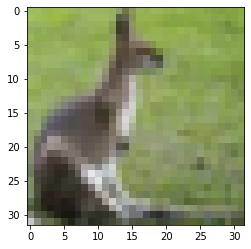

In [61]:
sample_index = 1234    # change here to try different
data_type = data_test  # = data_test or = data_train

# pick up a group (for batch norm)
imgs = data_type['data'][sample_index : sample_index + 64]

# first we shall resize the image to the target size (224, 224)
samples = []
for img in imgs: 
    samples.append(np.array(Image.fromarray(img).resize(resize)))
samples = torch.tensor(np.array(samples).transpose((0,3,1,2)) / 255., dtype = torch.float32)

# prediction through network
sample_pred = net(samples.to(_cuda_))
sample_pred = torch.nn.Softmax()(sample_pred)[0].cpu().detach().numpy()

sample_highest = np.argsort(sample_pred)[-5:][::-1]
sample_pred_names = [data_meta['fine_label_names'][i] for i in sample_highest]
sample_pred_prob  = [sample_pred[i] for i in sample_highest]

print('Label:', data_meta['fine_label_names'][data_type['fine_labels'][sample_index]])
print('Prediction:')
print('\n'.join(['%s%.4f'%(name.ljust(15), prob) for name, prob in zip(sample_pred_names,sample_pred_prob)]))
plt.imshow(imgs[0])
plt.show()